In [1]:
import os
import pprint
import gensim
import multiprocessing
from scipy.interpolate import spline
from scipy.fftpack import fft, ifft
import string

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from English_to_IPA import conversion
import re
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from num2words import num2words

In [3]:
class LyricsIterator(object):
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
    def __iter__(self):
        lyrics_data = pd.read_csv(self.dataset_name)
        for lyric in lyrics_data["text"]:
            yield split_lyric(lyric)

lyrics = LyricsIterator('LyricsFreak.csv')

In [4]:
categories = ['Oral Cavity',
              'Mouth Openness',
              'Obstruent',
              'Tongue Positioning',
              'Resonance',
              'Vowel','Round','Tense']
eSPEDict = dict()
with open('eSPEPhonologicalTableV2') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDict[line[0]] = np.array([eval(x) for x in line[1:]])

In [5]:
def split_lyric(lyrics):
    lyrics = re.sub('\n+', '\n', lyrics)
    splitted_lyrics = re.sub(' +', ' ', clean_lyric(lyrics)).split(' ')
    return [ word.lower() for word in splitted_lyrics if word != '']

def clean_lyric(lyric):
    punct_str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~«»“…‘”'
    for p in punct_str:
        lyric = lyric.replace(p,' ')
    return lyric   
    
def is_number(word):
    try:
        int(word)
        return True
    except ValueError:
        pass
    return False

def change_number_to_string(number):
    return num2words(int(number))

def is_empty(sequence):
    if len(sequence) == 0:
        return True
    return False

In [6]:
def get_score_from_lyric(lyrics):
    word_count = 0
    score = np.zeros((8,), dtype=np.int)
    words = split_lyric(lyrics)
    for word in words:
        if word == '':
            continue
        if is_number(word):
            #print("Found number: "+ word)
            word = change_number_to_string(word)
        cmu, ipa = conversion.convert(word)
        punct = '[ˌˈ ]'
        for p in punct:
            ipa = ipa.replace(p , '')
        if '*' in ipa:
            if word.endswith("in'"):
                word = word.replace("in'","ing")
                cmu,ipa = conversion.convert(word)
                punct = '[ˌˈ ]'
                for p in punct:
                    ipa = ipa.replace(p , '')
                if '*' in ipa:
                    #print('No IPA Found for: '+ word)
                    continue
            else:
                #print('No IPA Found for: '+ word)
                continue
        word_count += 1
        i = 0
        while i < len(ipa):
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDict[sym]
                i += 1
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDict[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDict[sym]
                    i += 1
    score = np.append(score, word_count)
    return score


      
            
def get_score_from_word(word):
    score = np.zeros((8,), dtype=np.int)
    if word == '':
        return -1
    if is_number(word):
        word = change_number_to_string(word)
    cmu, ipa = conversion.convert(word)
    ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
    if '*' in ipa:
        if word.endswith("in'"):
            word = word.replace("in'","ing")
            cmu,ipa = conversion.convert(word)
            punct = '[ˌˈ ]'
            for p in punct:
                ipa = ipa.replace(p , '')
            if '*' in ipa:
                #print('No IPA Found for: '+ word)
                return score
        else:
            #print('No IPA Found for: '+ word)
            return score
    i = 0
    while i < len(ipa):
        if i == len(ipa)-1:
            sym = ipa[i]
            score += eSPEDict[sym]
            i += 1
        else:
            try:
                sym = ipa[i] + ipa[i+1]
                score += eSPEDict[sym]
                i += 2
            except KeyError:
                sym = ipa[i]
                score += eSPEDict[sym]
                i += 1
    return score

def get_score_by_word(lyric):
    punct_str = '!"#$%&\()*+,-./:;<=>/?@[\\]^_`{|}~«»\n'
    for p in punct_str:
        lyric = lyric.replace(p,' ')
    lyric = re.sub('\n+', '\n', lyric)
    splitted_words = split_lyric(lyric)
    scores = []
    for word in splitted_words:
        if word != '':
            temporal_score = get_score_from_word(word)
        if np.count_nonzero(temporal_score) > 0:
            scores.append(temporal_score) 
    return scores
                
def get_score_by_sentence(lyric):
    lyric = clean_lyric(lyric)
    lyric = re.sub('\n+', '\n', lyric)
    splitted_sentences = lyric.split('\n')
    scores = []
    curated_sentences = []
    count = 1
    for sentence in splitted_sentences:
        temporal_score = get_score_from_lyric(sentence)
        if np.count_nonzero(temporal_score) > 0:
            curated_sentences.append(sentence)
            count += 1
            scores.append(temporal_score)
            #print(sentence)
            #print (sum(temporal_score[0:8])/temporal_score[8])
    return scores 

In [11]:
lyrics_data = pd.read_csv('LyricsFreak.csv')
lyric = lyrics_data["text"][0]

# By Sentence 

In [8]:
scores = get_score_by_sentence(lyric)

## Energy Frequency by Sentence/Category

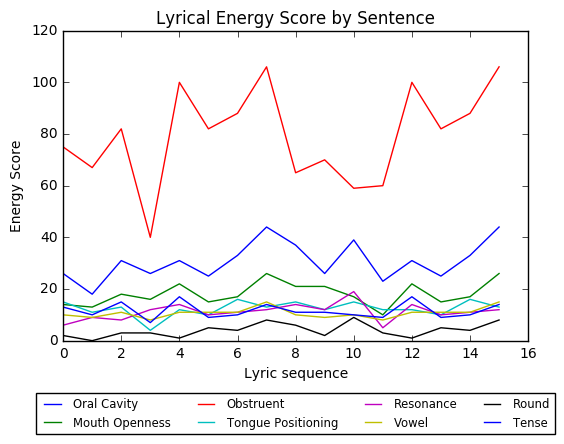

In [9]:
for i, category in enumerate(categories):
    plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.title("Lyrical Energy Score by Sentence")
plt.show()

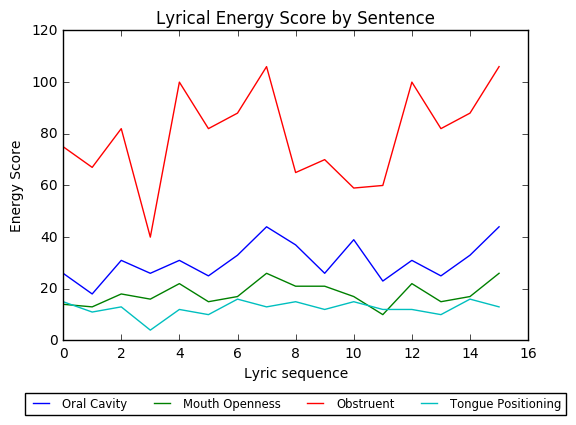

In [10]:
for i, category in enumerate(categories):
    if(i <= 3):
        plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.title("Lyrical Energy Score by Sentence")
plt.show()

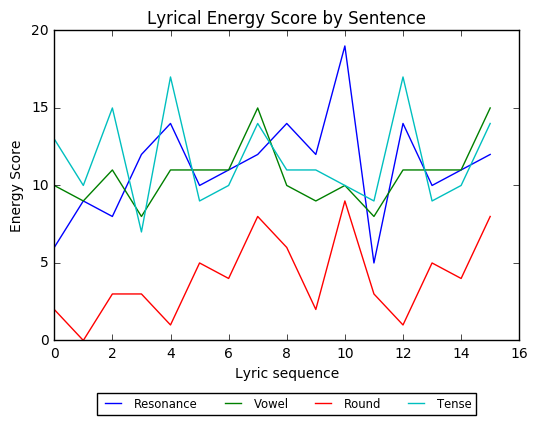

In [11]:
for i, category in enumerate(categories):
    if( i > 3):
        plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.title("Lyrical Energy Score by Sentence")
plt.show()

## Overall Energy Frequency by Sentence 

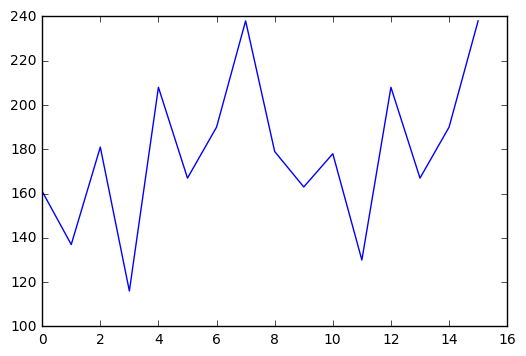

[161, 137, 181, 116, 208, 167, 190, 238, 179, 163, 178, 130, 208, 167, 190, 238]


In [12]:

fourier_norm = np.fft.fft(list(map(lambda x: sum(x[0:8])/x[8],scores)), norm='ortho')
lyric_score_by_sentence = list(map(lambda x: sum(x[0:8]),scores))

plt.plot(lyric_score_by_sentence)
#plt.plot(fourier)
#plt.plot(fourier_norm)
plt.show()
print(lyric_score_by_sentence)

## Fourier Transform - By Sentence

/Users/roblescoulter/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


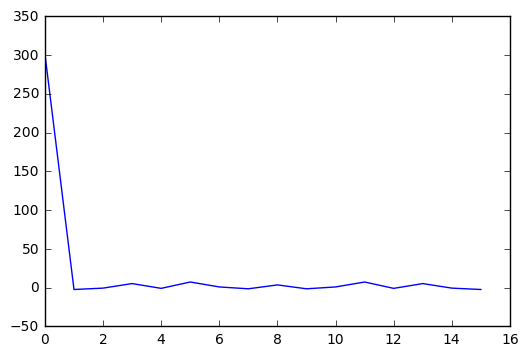

[ 301.51002886+0.j           -2.32384008+3.70161047j
   -0.54939324-5.47050128j    5.31158352+5.13197673j
   -0.86136364-5.15277778j    7.33442690-3.06403368j
    0.96302960-4.06141037j   -1.42217034-4.49439995j    3.58542569+0.j
   -1.42217034+4.49439995j    0.96302960+4.06141037j
    7.33442690+3.06403368j   -0.86136364+5.15277778j
    5.31158352-5.13197673j   -0.54939324+5.47050128j
   -2.32384008-3.70161047j]


In [13]:
energy_avg = list(map(lambda x: sum(x[0:8])/x[8],scores))
fourier = np.fft.fft(energy_avg)
plt.plot(fourier)
plt.show()
print(fourier)

# By word

In [14]:
scores = get_score_by_word(lyric)

## Energy Frequency by Word/Category

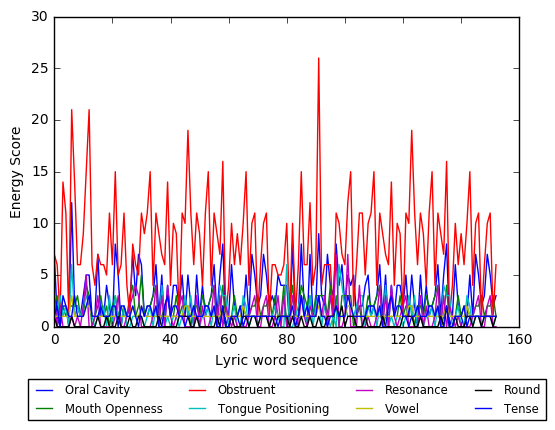

In [15]:
for i, category in enumerate(categories):
    plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric word sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.show()

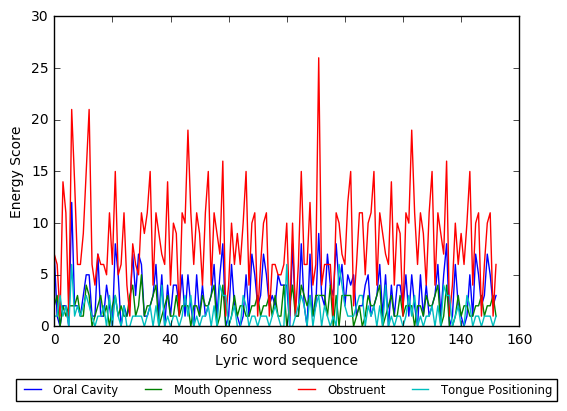

In [16]:
for i, category in enumerate(categories):
    if(i <= 3):
        plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric word sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.show()

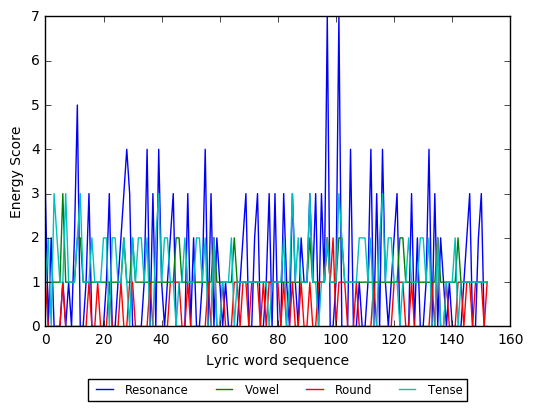

In [17]:
for i, category in enumerate(categories):
    if(i > 3):
        plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric word sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.show()

## Overall Energy Frequency by Word

/Users/roblescoulter/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


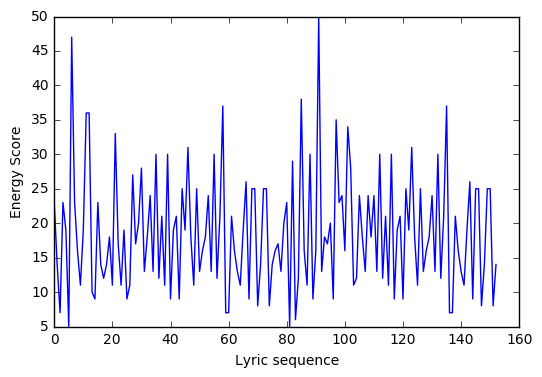

In [18]:
lyric_score_by_word = list(map(lambda x: sum(x[0:8]),scores))
plt.xlabel('Lyric sequence')
plt.ylabel('Energy Score')
plt.plot(lyric_score_by_word)
plt.legend()
plt.show()

## Fourier Transform - By Word

/Users/roblescoulter/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


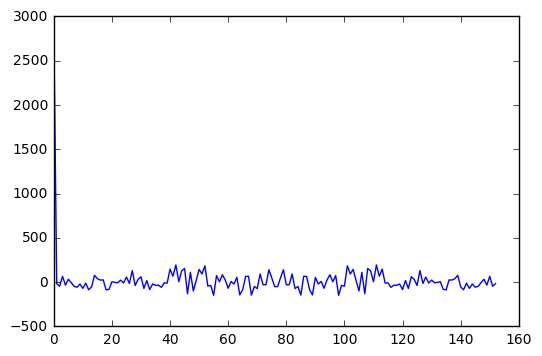

[ 2851.00000000  +0.j           -16.34822041 +40.48637365j
   -46.52603475 -62.06063665j    65.73522649 +19.13217321j
   -33.39298076 -57.71728427j    33.05136281 -70.52095793j
    -5.55440200 -20.39411871j   -46.87126411 -40.7952457j
   -57.09174105 +40.74249623j   -21.14340801 +20.45060179j
   -70.13415343 +48.18282181j   -11.11709699  -2.71016771j
   -86.07989233 +29.03882533j   -53.31986210 +41.5250428j
    77.20906404 -90.66720049j    39.85602485 +34.03882374j
    23.43063050 +14.56719144j    25.56982921 -49.9603856j
   -87.18283286 +36.55131077j   -80.60711097 +15.06157911j
     4.86412884 +56.39217218j    -3.15604011 +89.88923499j
    -6.93722208  +9.72179278j    23.14866726 +64.20245808j
    -9.49515330 -64.75827236j    58.04930310 +59.05770645j
   -14.43489762 +59.52999014j   131.38599093 +13.0262786j
   -37.49848183 -45.01656387j    31.83495741-111.05880759j
    61.07848643 -80.53629887j   -71.35833996 -87.29354786j
    18.32125910-143.09834137j   -84.24155620 -28.63417793j
 

In [19]:
fourier = np.fft.fft(lyric_score_by_word)
plt.plot(fourier)
plt.show()
print(fourier[:50])


# Evaluation of Energy Lyrics

In [54]:
def show_energy(file,song_name):
    temp = open(file,'r')
    lyric = temp.read()
    temp.close()
    scores = get_score_by_sentence(lyric)
    bysentence_scores = list(map(lambda x: sum(x[0:8]),scores))
    scores = get_score_by_word(lyric)
    byword_scores =  list(map(lambda x: sum(x[0:8]),scores))
    total_score = sum(byword_scores)/len(byword_scores)
    print('Average score: '+ str(total_score))
    print('Total score:' + str(sum(byword_scores)))
    plt.xlabel('Lyric sequence')
    plt.ylabel('Energy Score')
    plt.title(song_name)
    plt.plot(byword_scores)
    plt.show()
    #plt.xlabel('Lyric sequence')
    #plt.ylabel('Energy Score')
    #for i, category in enumerate(categories):
    #    plt.plot(list(map(lambda x: x[i],scores)), label=category)
    plt.plot(bysentence_scores)
    plt.show()

import scipy.io
    
def energy_array(file,array_file):
    temp = open(file,'r')
    lyric = temp.read()
    temp.close()
    scores = get_score_by_sentence(lyric)
    bysentence_scores = np.array(list(map(lambda x: sum(x[0:8]),scores)))
    scores = get_score_by_word(lyric)
    byword_scores = np.array(list(map(lambda x: sum(x[0:8]),scores)))
    #scipy.io.savemat(array_file+'_sentence.mat',bysentence_scores)
    #scipy.io.savemat(array_file+'_word.mat',byword_scores)
    return bysentence_scores, byword_scores
    

In [ ]:
show_energy('GoodLyricsExamples/lyric_1.txt', 'Rockstar - Post Malone')
show_energy('GoodLyricsExamples/lyric_2.txt', 'Havana - Camila Cabello')
show_energy('GoodLyricsExamples/lyric_3.txt', 'See you again - Charlie Puth Fast Furious')
show_energy('GoodLyricsExamples/lyric_4.txt', 'Start of something new')
show_energy('GoodLyricsExamples/lyric_5.txt', 'Treasure - Bruno Mars')
show_energy('GoodLyricsExamples/lyric_6.txt', 'Let her go - Passenger')
show_energy('GoodLyricsExamples/lyric_7.txt', 'Everybody - Backstreet Boys')

## "Bad" Lyrics

In [36]:
show_energy('BadLyricsExamples/lyric_1.txt', 'Stoney Bologne')
show_energy('BadLyricsExamples/lyric_2.txt', 'Its Everyday Bro - Jake Paul')
show_energy('BadLyricsExamples/lyric_3.txt', 'Drinkin too much - Sam Hunt')

## Billboard Songs

In [ ]:
show_energy('BillboardLyrics/finesse.txt', 'Finesse - Bruno Mars')
show_energy('BillboardLyrics/finesseremix.txt', 'Finesse (Remix) - Bruno Mars')
show_energy('BillboardLyrics/perfect.txt', 'Perfect - Ed Sheeran')
show_energy('BillboardLyrics/havana.txt', 'Havana - Camila Cabello')
show_energy('GoodLyricsExamples/lyric_5.txt', 'Treasure - Bruno Mars')

In [66]:
a,b = energy_array('BillboardLyrics/havana.txt','treasure')

In [67]:
temp = open('BillboardLyrics/havana.txt','r')
time_series = pd.read_csv("havanna_lrc.csv")
lyric = temp.read()
temp.close()

In [73]:
time_values = list(map(lambda x: (60 * int(x.split(':')[0]) + int(x.split(':')[1])), time_series["time_start"]))

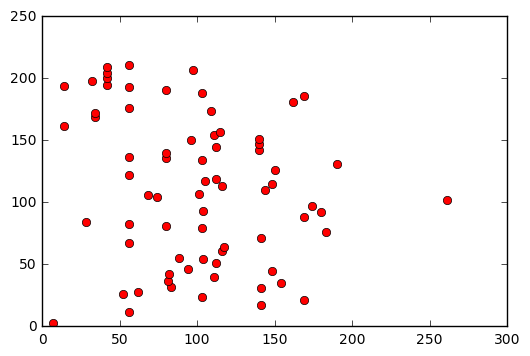

In [69]:
plt.plot(a, time_values, 'ro')
plt.show()

# Energy Builder

In [10]:
lyrics_data["energy_sequence_sentence"] = lyrics_data['text'].apply(get_score_by_sentence)

KeyError: '5'